# Семинар 11: Моделирование последовательностей. Реккурентные нейронные сети `RNN`, `LSTM` и `GRU`. Функция потерь `CTCLoss`.

In [1]:
import matplotlib.pyplot as plt
import numpy             as np

from torch.utils.tensorboard import SummaryWriter
from torch.nn                import functional as F
from torch.utils             import data
from torch                   import nn

from IPython     import display

import collections
import requests
import hashlib
import random
import torch
import math
import time
import re
import os

np.random.seed(seed=42)
torch.manual_seed(42)

device = torch.device("cuda")

2023-11-12 20:40:27.229214: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-12 20:40:28.152818: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Набор данных

В качестве данных используется книга Г.Уэллса "Машина времени". Текст был предварительно обработан с помощью кода, приведенного в [ссылка](https://colab.research.google.com/github/probml/pyprobml/blob/master/notebooks/text_preproc_torch.ipynb).

In [2]:
class SequenceDataLoader:
    """An iterator to load sequence data."""

    def __init__(self, batch_size, num_steps, use_random_iter, max_tokens):
        if use_random_iter:
            self.data_iter_fn = seq_data_iter_random
        else:
            self.data_iter_fn = seq_data_iter_sequential
        self.corpus, self.vocab = load_corpus_time_machine(max_tokens)
        self.batch_size, self.num_steps = batch_size, num_steps

    def __iter__(self):
        return self.data_iter_fn(self.corpus, self.batch_size, self.num_steps)

class Vocab:
    """Vocabulary for text."""
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        # Sort according to frequencies
        counter = count_corpus(tokens)
        self.token_freqs = sorted(counter.items(), key=lambda x: x[1], reverse=True)
        # The index for the unknown token is 0
        self.unk, uniq_tokens = 0, ["<unk>"] + reserved_tokens
        uniq_tokens += [token for token, freq in self.token_freqs if freq >= min_freq and token not in uniq_tokens]
        self.idx_to_token, self.token_to_idx = [], dict()
        for token in uniq_tokens:
            self.idx_to_token.append(token)
            self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

In [3]:
def tokenize(lines, token="word"):
    """Split text lines into word or character tokens."""
    if token == "word":
        return [line.split() for line in lines]
    elif token == "char":
        return [list(line) for line in lines]
    else:
        print("ERROR: unknown token type: " + token)

def count_corpus(tokens):
    """Count token frequencies."""
    # Here `tokens` is a 1D list or 2D list
    if len(tokens) == 0 or isinstance(tokens[0], list):
        # Flatten a list of token lists into a list of tokens
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)

def seq_data_iter_random(corpus, batch_size, num_steps):
    """Generate a minibatch of subsequences using random sampling."""
    # Start with a random offset (inclusive of `num_steps - 1`) to partition a
    # sequence
    corpus = corpus[random.randint(0, num_steps - 1) :]
    # Subtract 1 since we need to account for labels
    num_subseqs = (len(corpus) - 1) // num_steps
    # The starting indices for subsequences of length `num_steps`
    initial_indices = list(range(0, num_subseqs * num_steps, num_steps))
    # In random sampling, the subsequences from two adjacent random
    # minibatches during iteration are not necessarily adjacent on the
    # original sequence
    random.shuffle(initial_indices)

    def data(pos):
        # Return a sequence of length `num_steps` starting from `pos`
        return corpus[pos : pos + num_steps]

    num_batches = num_subseqs // batch_size
    for i in range(0, batch_size * num_batches, batch_size):
        # Here, `initial_indices` contains randomized starting indices for
        # subsequences
        initial_indices_per_batch = initial_indices[i : i + batch_size]
        X = [data(j) for j in initial_indices_per_batch]
        Y = [data(j + 1) for j in initial_indices_per_batch]
        yield torch.tensor(X), torch.tensor(Y)

def seq_data_iter_sequential(corpus, batch_size, num_steps):
    """Generate a minibatch of subsequences using sequential partitioning."""
    # Start with a random offset to partition a sequence
    offset = random.randint(0, num_steps)
    num_tokens = ((len(corpus) - offset - 1) // batch_size) * batch_size
    Xs = torch.tensor(corpus[offset : offset + num_tokens])
    Ys = torch.tensor(corpus[offset + 1 : offset + 1 + num_tokens])
    Xs, Ys = Xs.reshape(batch_size, -1), Ys.reshape(batch_size, -1)
    num_batches = Xs.shape[1] // num_steps
    for i in range(0, num_steps * num_batches, num_steps):
        X = Xs[:, i : i + num_steps]
        Y = Ys[:, i : i + num_steps]
        yield X, Y

In [4]:
def download(name, cache_dir=os.path.join(".", "data")):
    """Download a file inserted into DATA_HUB, return the local filename."""
    assert name in DATA_HUB, f"{name} does not exist in {DATA_HUB}."
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split("/")[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, "rb") as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # Hit cache
    print(f"Downloading {fname} from {url}...")
    r = requests.get(url, stream=True, verify=True)
    with open(fname, "wb") as f:
        f.write(r.content)
    return fname

def read_time_machine():
    """Load the time machine dataset into a list of text lines."""
    with open(download("time_machine"), "r") as f:
        lines = f.readlines()
    return [re.sub("[^A-Za-z]+", " ", line).strip().lower() for line in lines]

def load_corpus_time_machine(max_tokens=-1):
    """Return token indices and the vocabulary of the time machine dataset."""
    lines = read_time_machine()
    tokens = tokenize(lines, "char")
    vocab = Vocab(tokens)
    # Since each text line in the time machine dataset is not necessarily a
    # sentence or a paragraph, flatten all the text lines into a single list
    corpus = [vocab[token] for line in tokens for token in line]
    if max_tokens > 0:
        corpus = corpus[:max_tokens]
    return corpus, vocab

def load_data_time_machine(batch_size, num_steps, use_random_iter=False, max_tokens=10000):
    """Return the iterator and the vocabulary of the time machine dataset."""
    data_iter = SequenceDataLoader(batch_size, num_steps, use_random_iter, max_tokens)
    return data_iter, data_iter.vocab

In [5]:
DATA_HUB = dict()
DATA_URL = "http://d2l-data.s3-accelerate.amazonaws.com/"
DATA_HUB["time_machine"] = (DATA_URL + "timemachine.txt", "090b5e7e70c295757f55df93cb0a180b9691891a")

batch_size, num_steps = 32, 35
train_iter, vocab = load_data_time_machine(batch_size, num_steps)

$X_t \in R^{n{\times}d}$, матрица входных данных (one-hot), где n - размер пакета данных, d - размер словаря.

$H_t \in R^{n{\times}h}$, матрица скрытых состояний, где h - длина вектора скрытых состояний

$O_t \in R^{n{\times}q}$, матрица выходных данных для q выходных значений (часто q=d)

In [6]:
!head -n 20 data/timemachine.txt

The Time Machine, by H. G. Wells [1898]




I


The Time Traveller (for so it will be convenient to speak of him)
was expounding a recondite matter to us. His grey eyes shone and
twinkled, and his usually pale face was flushed and animated. The
fire burned brightly, and the soft radiance of the incandescent
lights in the lilies of silver caught the bubbles that flashed and
passed in our glasses. Our chairs, being his patents, embraced and
caressed us rather than submitted to be sat upon, and there was that
luxurious after-dinner atmosphere when thought roams gracefully
free of the trammels of precision. And he put it to us in this
way--marking the points with a lean forefinger--as we sat and lazily
admired his earnestness over this new paradox (as we thought it)
and his fecundity.


## Что будем предсказывать (генерировать)?

Мы будем передавать начальную префиксную строку (массив символов), которая используется для `разогрева` вектора скрытых состояний. То есть мы обновляем скрытое состояние с учетом наблюдаемого префикса, но ничего не генерируем. После этого для каждого из `num_preds` шагов мы вычисляем выходной тензор `(1,d)`, выбираем индекс argmax и добавляем его к выходу. Наконец, мы преобразуем индексы в `воспринимаемую пользователем` последовательность лексем размера `(1,num_preds)`. 

***Обратите внимание, что это жадная, детерминированная процедура***.

In [7]:
from torch.nn.functional import one_hot

def predict(prefix, num_preds, model, vocab, device):
    """Generate new characters following the `prefix`."""
    state = model.init_hidden()
    
    outputs = [vocab[prefix[0]]]
    get_input = lambda: one_hot( torch.tensor([outputs[-1]], device=device).reshape((1,1)), len(vocab) )
    for y in prefix[1:]:  # Warm-up period
        _, state = model(get_input(), state)
        outputs.append(vocab[y])
    for _ in range(num_preds):  # Predict `num_preds` steps
        y, state = model(get_input(), state)
        outputs.append(int(y.argmax(dim=1).reshape(1)))
    return "".join([vocab.idx_to_token[i] for i in outputs])

## Как будем оценивать качество?



Добавить текст про перплексию

## Как будем тренировать?

Для того чтобы ограничить градиент при обратном распространении в рекуррентной нейронной сети, мы используем обрезание градиента, что соответствует обновлению
$$
g := \min(1, \theta /||g||) g
$$
где $\theta$ - масштабный параметр, а $g$ - вектор градиента.

In [31]:
def grad_clipping(net, theta):
    """Clip the gradient."""
    params = [p for p in net.parameters() if p.requires_grad]
    norm = torch.sqrt(sum(torch.sum((p.grad**2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

In [9]:
class Animator:
    """For plotting data in animation."""

    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None, ylim=None, xscale="linear", yscale="linear", fmts=("-", "m--", "g-.", "r:"), nrows=1, ncols=1,
        figsize=(5.5, 4.5),
    ):
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        display.set_matplotlib_formats("svg")
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [
                self.axes,
            ]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: set_axes(self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

class Accumulator:
    """For accumulating sums over `n` variables."""

    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

class Timer:
    """Record multiple running times."""

    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        """Start the timer."""
        self.tik = time.time()

    def stop(self):
        """Stop the timer and record the time in a list."""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """Return the average time."""
        return sum(self.times) / len(self.times)

    def sum(self):
        """Return the sum of time."""
        return sum(self.times)

    def cumsum(self):
        """Return the accumulated time."""
        return np.array(self.times).cumsum().tolist()

def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """Set the axes for matplotlib."""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()

Шаг обучения достаточно стандартен, за исключением обрезания градиента и также особенности, связанной с вектором скрытых состоянии. Если итератор данных использует случайный порядок последовательностей, то инициализировать скрытое состояние необходимо для каждого минипакета. Если же итератор данных использует последовательный порядок, то инициализация скрытого состояния производится только в самом начале процесса. В последнем случае скрытое состояние будет зависеть от значения в предыдущем минипакете. Мы отсоединяем вектор состояния, чтобы предотвратить перетекание градиентов через границы минибатчей. 

In [10]:
from torch.nn.functional import one_hot

def train_epoch(model, train_dataset, loss_fn, optimizer, device, use_random_iter):
    state, timer = None, Timer()
    metric = Accumulator(2)  # Sum of training loss, no. of tokens
    for X, Y in train_dataset:
        
        if state is None or use_random_iter:
            # Initialize `state` when either it is the first iteration or using random sampling
            state = model.init_hidden(batch_size=X.shape[0])
        else:
            if isinstance(model, nn.Module) and not isinstance(state, tuple):
                # `state` is a tensor for `nn.GRU`
                state.detach_()
            else:
                # `state` is a tuple of tensors for `nn.LSTM` and for our custom scratch implementation
                for s in state:
                    s.detach_()

        X    = one_hot(X.T, num_classes=len(vocab)).type(torch.float32)
        y    = Y.T.reshape(-1)  # (B,T) -> (T,B)
        X, y = X.to(device), y.to(device)

        y_hat, state = model(X, state)
        l = loss_fn(y_hat, y.long()).mean()
        
        optimizer.zero_grad()
        l.backward()
        grad_clipping(model, 1)
        optimizer.step()
        metric.add(l * y.numel(), y.numel())
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()

Основная функция обучения достаточно стандартна. В качестве функции потерь используется кросс-энтропия для каждого символа, $-\log q(x_t)$, где $q$ - предсказание модели от RNN. Поскольку мы вычисляем среднее значение потерь по временным шагам в рамках пакета данных, то $-\frac{1}{T} \sum_{t=1}^T \log p(x_t|x_{1:t-1})$. Экспоненциальная величина этого показателя и есть перплеския (ppl). Мы строим график этой метрики в процессе обучения, поскольку она не зависит от длины документа. Кроме того, мы выводим MAP-предсказание последовательности после суффикса 'time traveller', чтобы получить представление о том, что делает модель.

In [11]:
def train(model, train_iter, vocab, lr, num_epochs, device, use_random_iter=False):
    animator = Animator(xlabel="epoch", ylabel="perplexity", legend=["train"], xlim=[10, num_epochs])
    
    loss_fn   = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr)
        
    num_preds = 50
    predict_ = lambda prefix: predict(prefix, num_preds, model, vocab, device)
    # Train and predict
    for epoch in range(num_epochs):
        ppl, speed = train_epoch(model, train_iter, loss_fn, optimizer, device, use_random_iter)
        if (epoch + 1) % 10 == 0:
            print(predict_("time traveller"))
            animator.add(epoch + 1, [ppl])
    print(f"perplexity {ppl:.1f}, {speed:.1f} tokens/sec on {str(device)}")
    print(predict_("time traveller"))
    print(predict_("traveller"     ))

## RNN (recurrent neural network)

Обозначения:

<img src="https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM2-notation.png" width=500 height=500 />

Схема модели:

<img src="https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-SimpleRNN.png" width=1000 height=1000 />


Формула модели:

$$\begin{align}
h_t &= \phi(X_t W_{xh} + H_{t-1}  W_{hh} + b_h) \\
O_t &= h_t W_{hq} + b_q
\end{align}
$$

In [12]:
from torch.nn import init

class CustomRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CustomRNN, self).__init__()
        
        self.hidden_size = hidden_size

        self.i2h     = nn.Linear(input_size + hidden_size, hidden_size)
        self.h2o     = nn.Linear(hidden_size, output_size)
                
        init.normal_(self.i2h.weight, std=0.01)
        init.zeros_ (self.i2h.bias  )
        init.normal_(self.h2o.weight, std=0.01)
        init.zeros_ (self.h2o.bias  )
        
    def __step(self, input_s, hidden_s):
        combined = torch.cat((input_s, hidden_s),1)
        hidden_s = torch.tanh( self.i2h(combined) )
        output_s = self.h2o    (hidden_s)
        return output_s, hidden_s
    def forward(self, input_ss, hidden_s):
        # `input_s`  shape: (`num_steps`, `batch_size`, `vocab_size`)
        # `hidden_s` shape: (`batch_size`, `hidden_size`)
        num_steps, batch_size, vocab_size = input_ss.shape
        (hidden_0,) = hidden_s
        
        output_ss = []
        for i in range(num_steps):
            input_s = input_ss[i]
            output_s, hidden_0 = self.__step(input_s, hidden_0)
            output_ss.append(output_s)
               
        return torch.cat(output_ss, dim=0), (hidden_0, )

    def init_hidden(self, batch_size = 1):
        return (torch.zeros(batch_size, self.hidden_size).to(device),)

In [13]:
# Check custom model
batch_size, time_steps, hidden_size  = 2, 10, 512
input_size  = len(vocab)
output_size = len(vocab)

model    = CustomRNN(input_size, hidden_size, output_size).to(device)

hidden_s = model.init_hidden(batch_size)

input_ss  = torch.zeros( time_steps, batch_size, input_size ).to(device)
output_ss, hidden_s = model(input_ss, hidden_s)

In [14]:
hidden_size = 512
input_size  = len(vocab)
output_size = len(vocab)

model = CustomRNN(input_size, hidden_size, output_size).to(device)

In [15]:
# sample 10 characters after the prefix. since the model is untrained, the results will be garbage.
predict("time traveller ", 10, model, vocab, device)

'time traveller iwksmhyqoa'

perplexity 1.0, 81400.5 tokens/sec on cuda
time traveller for so it will be convenient to speak of himwas e
traveller with a slight accession ofcheerfulness really thi


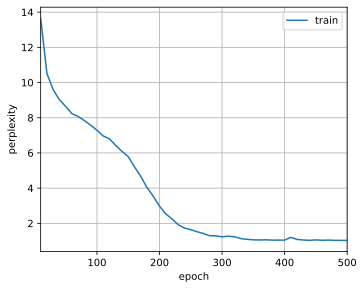

In [16]:
num_epochs, lr = 500, 1

train(model, train_iter, vocab, lr, num_epochs, device)

## LSTM

Схема модели:

<img src="https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-chain.png" width=1000 height=1000 />

Формулы пересчета состояний:

\begin{align}
f_t &= \sigma(W_f[x_t, h_{t-1}] + b_f) \\
i_t &= \sigma(W_i[x_t, h_{t-1}] + b_i) \\
o_t &= \sigma(W_o[x_t, h_{t-1}] + b_o) \\
\tilde{C}_t &= \tanh(W_C[x_t, h_{t-1}] + b_C) \\
C_t &= f_t \odot C_{t-1} + i_t \odot \tilde{C}_t \\
h_t &= o_t \odot \tanh(C_t)
\end{align}



In [40]:
from torch.nn import init

class CustomLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CustomLSTM, self).__init__()

        self.input_size  = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.xh2f     = nn.Linear(input_size + hidden_size, hidden_size)
        self.xh2i     = nn.Linear(input_size + hidden_size, hidden_size)
        self.xh2o     = nn.Linear(input_size + hidden_size, hidden_size)
        self.xh2C     = nn.Linear(input_size + hidden_size, hidden_size)
        self.h2y      = nn.Linear(hidden_size             , output_size)
        
        init.normal_(self.xh2f.weight, std=0.01)
        init.zeros_ (self.xh2f.bias            )
        init.normal_(self.xh2i.weight, std=0.01)
        init.zeros_ (self.xh2i.bias            )
        init.normal_(self.xh2o.weight, std=0.01)
        init.zeros_ (self.xh2o.bias            )
        init.normal_(self.xh2C.weight, std=0.01)
        init.zeros_ (self.xh2C.bias            )
        init.normal_(self.h2y.weight , std=0.01)
        init.zeros_ (self.h2y.bias             )
        
    def __step(self, input_s, H_s, C_s):
        xh = torch.cat((input_s, H_s), 1)
        
        I       = torch.sigmoid(self.xh2i(xh))
        F       = torch.sigmoid(self.xh2f(xh))
        O       = torch.sigmoid(self.xh2o(xh))
        C_tilda = torch.tanh   (self.xh2C(xh))
        C_s     = F * C_s + I * C_tilda
        H_s     = O * torch.tanh(C_s)
        output_s  = self.h2y(H_s)
        
        return output_s, (H_s, C_s)
    def forward(self, input_ss, hidden_s):
        # `input_s`  shape: (`num_steps`, `batch_size`, `vocab_size`)
        # `hidden_s` shape: (`batch_size`, `hidden_size`),(`batch_size`,`hidden_size`)
        num_steps, batch_size, vocab_size = input_ss.shape
        (H_s, C_s) = hidden_s
        
        output_ss = []
        for i in range(num_steps):
            input_s = input_ss[i]
            output_s, (H_s, C_s) = self.__step(input_s, H_s, C_s)
            output_ss.append(output_s)
               
        return torch.cat(output_ss, dim=0), (H_s, C_s)

    def init_hidden(self, batch_size = 1):
        return (torch.zeros((batch_size, self.hidden_size), device=device),torch.zeros((batch_size, self.hidden_size), device=device),)

In [41]:
# Check custom model
batch_size, time_steps, hidden_size  = 2, 10, 512
input_size  = len(vocab)
output_size = len(vocab)

model    = CustomLSTM(input_size, hidden_size, output_size).to(device)

hidden_s = model.init_hidden(batch_size)

input_ss  = torch.zeros( time_steps, batch_size, input_size ).to(device)
output_ss, hidden_s = model(input_ss, hidden_s)

In [42]:
hidden_size = 256
input_size  = len(vocab)
output_size = len(vocab)

model = CustomLSTM(input_size, hidden_size, output_size).to(device)

In [43]:
# sample 10 characters after the prefix. since the model is untrained, the results will be garbage.
predict("time traveller ", 10, model, vocab, device)

'time traveller hcav hcav '

perplexity 1.0, 12706.6 tokens/sec on cuda
time travelleryou can show black is white by argument said filby
travelleryou can show black is white by argument said filby


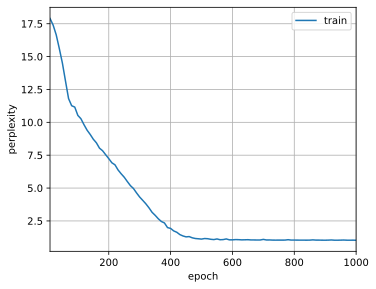

In [44]:
num_epochs, lr = 500, 1

train(model, train_iter, vocab, lr, num_epochs, device)

### GRU

GRU (Gated recurrent unit) - это более простая версия LSTM.

Схема модели:

<img src="https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-var-GRU.png" width=1000 height=1000 />

In [50]:
from torch.nn import init

class CustomGRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CustomGRU, self).__init__()

        self.input_size  = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.xh2z     = nn.Linear(input_size + hidden_size, hidden_size)
        self.xh2r     = nn.Linear(input_size + hidden_size, hidden_size)
        self.xrh2h    = nn.Linear(input_size + hidden_size, hidden_size)
        
        self.h2y      = nn.Linear(hidden_size             , output_size)
        
        init.normal_(self.xh2z.weight, std=0.01 )
        init.zeros_ (self.xh2z.bias             )
        init.normal_(self.xh2r.weight, std=0.01 )
        init.zeros_ (self.xh2r.bias             )
        init.normal_(self.xrh2h.weight, std=0.01)
        init.zeros_ (self.xrh2h.bias            )
        init.normal_(self.h2y.weight, std=0.01  )
        init.zeros_ (self.h2y.bias              )
        
                
    def __step(self, X, H):
        XH = torch.cat((X, H), 1)
        
        Z = torch.sigmoid(self.xh2z(XH))
        R = torch.sigmoid(self.xh2r(XH))

        XRH = torch.cat((X, R*H), 1)
        H_tilda = torch.tanh(self.xrh2h(XRH))
        H = Z * H + (1 - Z) * H_tilda
        Y = self.h2y(H)
               
        return Y, H
    def forward(self, input_ss, hidden_s):
        # `input_s`  shape: (`num_steps`, `batch_size`, `vocab_size`)
        # `hidden_s` shape: (`batch_size`, `hidden_size`),(`batch_size`,`hidden_size`)
        num_steps, batch_size, vocab_size = input_ss.shape
        (H_s,) = hidden_s
        
        output_ss = []
        for i in range(num_steps):
            input_s = input_ss[i]
            output_s, H_s  = self.__step(input_s, H_s)
            output_ss.append(output_s)
               
        return torch.cat(output_ss, dim=0), (H_s,)

    def init_hidden(self, batch_size = 1):
        return (torch.zeros((batch_size, self.hidden_size), device=device),)

In [51]:
# Check custom model
batch_size, time_steps, hidden_size  = 2, 10, 512
input_size  = len(vocab)
output_size = len(vocab)

model    = CustomGRU(input_size, hidden_size, output_size).to(device)

hidden_s = model.init_hidden(batch_size)

input_ss  = torch.zeros( time_steps, batch_size, input_size ).to(device)
output_ss, hidden_s = model(input_ss, hidden_s)

In [54]:
hidden_size = 256
input_size  = len(vocab)
output_size = len(vocab)

model = CustomGRU(input_size, hidden_size, output_size).to(device)

In [55]:
# sample 10 characters after the prefix. since the model is untrained, the results will be garbage.
predict("time traveller ", 10, model, vocab, device)

'time traveller pppydydyj<unk>'

perplexity 1.1, 15944.5 tokens/sec on cuda
time traveller for so it will be convenient to speak of himwas e
traveller with a slight accession ofcheerfulness really thi


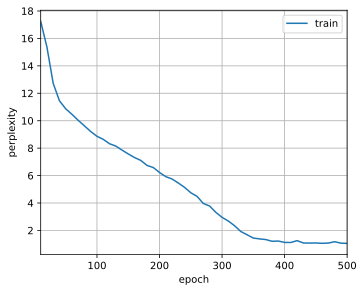

In [56]:
num_epochs, lr = 500, 1

train(model, train_iter, vocab, lr, num_epochs, device)

## Задача распознавания текста на изображении

Мы не будем затрагивать тему локализации номеров на изображении $-$ это задача может быть решена моделями детектирования или сегментации. Сосредоточимся на "чтении" текста знаков на уже подготовленных кропах.

#### План:
1. Общая схема
2. Подготовка данных
3. Построение модели `CRNN` (`Convolutional Recurrent Neural Network`). Краткое описание работы `CTC Loss`.
4. Интерфейс и применение функции потерь `CTC Loss` (`Connectionist Temporal Classification`)
5. Обучение и результаты
6. Анализ проблем и домашнее задание

### Общая схема

<img src="resources/black_box.png" alt="drawing" width="1200"/>

Задачу распознавания текста на изображении можно рассматривать под разными углами:
- Как классификацию (1 слово = 1 класс);
- Как классификацию отдельных символов (то есть сначала разрезать на символы, затем каждый отдельно "прочитать");
- Как предсказание последовательностей (фиксированной или переменной длины).

Первый подход очевидно очень плох.
* **TODO: Почему?**
Во-первых, при обучении мы будем иметь дело с очень разреженными данными (вероятно, для каких-то "классов"-слов у нас будет только по одному примеру), а в боевых данных могут оказаться слова, которых в обучающей выборке не было вовсе. Во-вторых, это классификация на гигантское число классов - такую модель будет очень непросто обучить. Однако, если в задаче сильно ограничен словарь (множество "слов"), то эту схему можно использовать (например, если вы хотите распознавать номера футболистов на форме).

Второй подход тоже не лишен недостатков. 
* **TODO: Каких?** 
Самый очевидный - необходимо уметь хорошо разрезать слова на отдельные символы. В случае изображений из реальной жизни возникают дополнительные сложности в виде экзотических шрифтов, не позволяющих адекватно разделять соседние символы, шумов и т.д.

Третий подход не требует специальной подготовки данных и прост с точки зрения архитектуры. К нему мы и обратимся.

#### Convolutional Recurrent Neural Network (CRNN)

[paper](https://arxiv.org/abs/1507.05717)

![crnn](resources/crnn.png)

Модель CRNN (не путайте с R-CNN - семейством детекторов) предназначена для перевода изображений в текстовый вид. Она устроена следующим образом (см.изображение выше):
1. Первый этап - извлечение признаков. Входное изображение пропускается через последовательность сверточных слоев (с активациями, пулингом, вот эти вот всем), в результате чего получается тензор признаков размера, например, `C x H x W`. Если рассматривать в отдельности каждый из срезов вдоль оси "ширины" (`W`, последняя размерность), то можно сказать, что у нас получилась последовательность длины `W`. Каждый из этих элементов соответствует определенной области на исходном изображении: ![receptive](resources/receptive.png)
2. Второй этап - предсказание вероятностей каждого из символов алфавита **для каждого элемента последовательности**. Полученная на первом шаге последовательность признаков пропускается через рекуррентную сеть, в результате чего на выходе образуется последовательность той же длины, что и на входе. Размер каждого элемента равен мощности алфавита + 1 (этот "+1" - символ `blank` для использования `CTC-Loss`).
3. Третий этап - либо декодирование ("транскрипция") полученных на предыдущем шаге распределений в итоговый текст (при инференсе), либо вычисление `CTC-Loss` между полученными распределениями и `ground-truth`-последовательностями.

Быстрый FAQ:
* Q: Длина предсказанных последовательностей после первого шага фиксирована?
  
  A: Да, если используются батчи с изображениями одинакового размера.

* Q: Как из "двумерных" элементов после первого шага получаются "столбики" (как на картинке выше)?
  
  A: Можно сделать разворачивание в столбец (размер элементов станет -> `C * H`), пулинг по высоте (-> `C`), линейный слой, <ваш вариант>, ...

* Q: Длина предсказанных последовательностй после второго шага равна длине предсказанных в итоге слов?

  A: Нет, ее следует сделать больше. На последнем шаге используется `CTC-Loss`, который умеет "сжимать" предсказанные последовательности (в том числе с помощью `blank`-символов).
  
  
* Q: Как работает `CTC-Loss`?

  A: Прочитайте [статью](https://www.cs.toronto.edu/~graves/icml_2006.pdf), смотрите [видео](https://www.youtube.com/watch?v=eYIL4TMAeRI), ...

### 2. CTC-loss

<img src="https://sid2697.github.io/Blog_Sid/assets/images/CTC_2.png" width=500 height=500 />

- Кодирование текста. У нас в модель приходит изображение фиксированного размера, результат работы модели есть матрица фиксированного размера (количество символов алфавита X длина последовательности). Распознаваемый текст может быть меньше. Тогда сформулируем следующее правило кодирования строк, где $"-"$ сервисный символ

$$
\begin{array}{ll}
“to” &→ “---ttttttooo”, или “-t-o-”, или “to” \\
“too” &→ “---ttttto-o”, или “-t-o-o-”, или “to-o”, но\ не “too”
\end{array}
$$
- Вычисление функции потерь

<img src="https://miro.medium.com/max/800/1*BFQYgGofh6HOxnGdkJnO-w.png" width=500 height=500 />

“a" → “aa”, “a–”, “–a“ → $P("a") = 0.4·0.4+0.4·0.6+0.6·0.4=0.64$

Теперь мы можем вычислить вероятность того, что текст `ground-truth` обучающей выборки является правильным (задача классификации), учитывая выходную матрицу, созданную нашей моделью

- Декодирование текста

<img src="https://miro.medium.com/max/1200/1*1_5KnLvaTkGUFoyat2jHcQ.png" width=500 height=500 />

$$
\begin{array}{ll}
“---ttttttooo”, или “-t-o-”, или “to”    &→ “to” \\
“---ttttto-o”, или “-t-o-o-”, или “to-o” &→ “too”
\end{array}
$$

## Тренировка рекуррентных нейроных сетей

One of the main challenges in sequence modelling is to predict the next symbol (vector) in the sequence.

**Extrapolation** or prediction is one of the most important and challenging tasks.

This can be viewed as **seq2seq** problem: given $x_1, \ldots, x_T$ we want a model to output $x_2, \ldots, x_{T+1}$.

A widely used loss in this context is Connectionist temporal classification (CTC) loss.

## CTC loss

Достаточно сложная функция потерь, используется в задачах, где нам нужно сопоставить входной последовательности последовательность одной длины с выходной последовательностью другой длины.

There a lot of alignments, so dynamic programming needs to be used.

$$\mathcal{L}_{\text{CTC}}=-\sum_{\pi \in \mathcal{B}(y)}p(\pi|x)$$

where:
- $\mathcal{L}_{\text{CTC}}$ is the CTC loss
- $\mathcal{B}(y)$ is the set of all possible alignments of the target sequence $y$
- $p(\pi|x)$ is the probability of alignment $\pi$ given the input sequence $x$.

Преимущества:

1. Рекуррентные нейронные сети запоминает информацию в течение времени. Они полезны в прогнозировании временных рядов только благодаря свойству "запоминать" предыдущие входы.
2. Рекуррентные нейронные сети используются с сверточными слоями для расширения эффективной окрестности пикселя.

Недостатки:

1. Проблемы исчезновения и взрыва градиента.
2. Обучение реккурентной нейронной сети является очень сложной задачей.
3. Реккурентная нейронная сеть не может обрабатывать очень длинные последовательности, если в качестве функции активации используется $tanh$ или $relu$.

Сегодня мы займемся задачей распознавания текста на изображениях, точнее задачей распознавания автомобильных номеров.

Мы не будем затрагивать тему локализации номеров на изображении $-$ это задача может быть решена моделями детектирования или сегментации. Сосредоточимся на "чтении" текста знаков на уже подготовленных кропах.

#### План:
1. Общая схема
2. Подготовка данных
3. Построение модели `CRNN` (`Convolutional Recurrent Neural Network`). Краткое описание работы `CTC Loss`.
4. Интерфейс и применение функции потерь `CTC Loss` (`Connectionist Temporal Classification`)
5. Обучение и результаты
6. Анализ проблем и домашнее задание

### 1. Общая схема

![box](resources/black_box.png)

Задачу распознавания текста на изображении можно рассматривать под разными углами:
- Как классификацию (1 слово = 1 класс);
- Как классификацию отдельных символов (то есть сначала разрезать на символы, затем каждый отдельно "прочитать");
- Как предсказание последовательностей (фиксированной или переменной длины).

Первый подход очевидно очень плох.
* **TODO: Почему?**
Во-первых, при обучении мы будем иметь дело с очень разреженными данными (вероятно, для каких-то "классов"-слов у нас будет только по одному примеру), а в боевых данных могут оказаться слова, которых в обучающей выборке не было вовсе. Во-вторых, это классификация на гигантское число классов - такую модель будет очень непросто обучить. Однако, если в задаче сильно ограничен словарь (множество "слов"), то эту схему можно использовать (например, если вы хотите распознавать номера футболистов на форме).

Второй подход тоже не лишен недостатков. 
* **TODO: Каких?** 
Самый очевидный - необходимо уметь хорошо разрезать слова на отдельные символы. В случае изображений из реальной жизни возникают дополнительные сложности в виде экзотических шрифтов, не позволяющих адекватно разделять соседние символы, шумов и т.д.

Третий подход не требует специальной подготовки данных и прост с точки зрения архитектуры. К нему мы и обратимся.

#### Convolutional Recurrent Neural Network (CRNN)

[paper](https://arxiv.org/abs/1507.05717)

![crnn](resources/crnn.png)

Модель CRNN (не путайте с R-CNN - семейством детекторов) предназначена для перевода изображений в текстовый вид. Она устроена следующим образом (см.изображение выше):
1. Первый этап - извлечение признаков. Входное изображение пропускается через последовательность сверточных слоев (с активациями, пулингом, вот эти вот всем), в результате чего получается тензор признаков размера, например, `C x H x W`. Если рассматривать в отдельности каждый из срезов вдоль оси "ширины" (`W`, последняя размерность), то можно сказать, что у нас получилась последовательность длины `W`. Каждый из этих элементов соответствует определенной области на исходном изображении: ![receptive](resources/receptive.png)
2. Второй этап - предсказание вероятностей каждого из символов алфавита **для каждого элемента последовательности**. Полученная на первом шаге последовательность признаков пропускается через рекуррентную сеть, в результате чего на выходе образуется последовательность той же длины, что и на входе. Размер каждого элемента равен мощности алфавита + 1 (этот "+1" - символ `blank` для использования `CTC-Loss`).
3. Третий этап - либо декодирование ("транскрипция") полученных на предыдущем шаге распределений в итоговый текст (при инференсе), либо вычисление `CTC-Loss` между полученными распределениями и `ground-truth`-последовательностями.

Быстрый FAQ:
* Q: Длина предсказанных последовательностей после первого шага фиксирована?
  
  A: Да, если используются батчи с изображениями одинакового размера.

* Q: Как из "двумерных" элементов после первого шага получаются "столбики" (как на картинке выше)?
  
  A: Можно сделать разворачивание в столбец (размер элементов станет -> `C * H`), пулинг по высоте (-> `C`), линейный слой, <ваш вариант>, ...

* Q: Длина предсказанных последовательностй после второго шага равна длине предсказанных в итоге слов?

  A: Нет, ее следует сделать больше. На последнем шаге используется `CTC-Loss`, который умеет "сжимать" предсказанные последовательности (в том числе с помощью `blank`-символов).
  
  
* Q: Как работает `CTC-Loss`?

  A: Прочитайте [статью](https://www.cs.toronto.edu/~graves/icml_2006.pdf), смотрите [видео](https://www.youtube.com/watch?v=eYIL4TMAeRI), ...

### 2. CTC-loss

<img src="https://sid2697.github.io/Blog_Sid/assets/images/CTC_2.png" width=500 height=500 />

- Кодирование текста. У нас в модель приходит изображение фиксированного размера, результат работы модели есть матрица фиксированного размера (количество символов алфавита X длина последовательности). Распознаваемый текст может быть меньше. Тогда сформулируем следующее правило кодирования строк, где $"-"$ сервисный символ

$$
\begin{array}{ll}
“to” &→ “---ttttttooo”, или “-t-o-”, или “to” \\
“too” &→ “---ttttto-o”, или “-t-o-o-”, или “to-o”, но\ не “too”
\end{array}
$$
- Вычисление функции потерь

<img src="https://miro.medium.com/max/800/1*BFQYgGofh6HOxnGdkJnO-w.png" width=500 height=500 />

“a" → “aa”, “a–”, “–a“ → $P("a") = 0.4·0.4+0.4·0.6+0.6·0.4=0.64$

Теперь мы можем вычислить вероятность того, что текст `ground-truth` обучающей выборки является правильным (задача классификации), учитывая выходную матрицу, созданную нашей моделью

- Декодирование текста

<img src="https://miro.medium.com/max/1200/1*1_5KnLvaTkGUFoyat2jHcQ.png" width=500 height=500 />

$$
\begin{array}{ll}
“---ttttttooo”, или “-t-o-”, или “to”    &→ “to” \\
“---ttttto-o”, или “-t-o-o-”, или “to-o” &→ “too”
\end{array}
$$

### 3. Подготовка данных

Набор даных для ноутбука: https://disk.yandex.ru/d/oJEpk4OGWxOOhg
Веса предобученной модели: https://disk.yandex.ru/d/kTyNnqE79x-njg

In [ ]:
import os
import cv2
import tqdm
import json
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn import Module, Sequential, Conv2d, AvgPool2d, GRU, Linear
from torch.nn.functional import ctc_loss, log_softmax
from torchvision import models

from string import digits, ascii_uppercase

np.random.seed(1234)

Датасет представляет собой размеченные изображения автомобильных номеров РФ, собранных из интернета либо сгенерированных автоматически.
Формат данных = папка с изображениями + файл конфигурации, в котором в виде списка хранятся записи о тексте на каждом из изображений.

In [ ]:
#PATH_TO_DATA = "./seminar09_data/"  # Change to your path with unzipped data
PATH_TO_DATA = "./data/"  # Change to your path with unzipped data

In [ ]:
config_path = os.path.join(PATH_TO_DATA, "config.json")
images_path = os.path.join(PATH_TO_DATA, "images")
assert os.path.isfile(config_path)
assert os.path.isdir(images_path)

with open(config_path, "rt") as fp:
    config = json.load(fp)

config_full_paths = []
for item in config:
    config_full_paths.append({"file": os.path.join(images_path, item["file"]),
                              "text": item["text"]})
config = config_full_paths

In [ ]:
print("Total items in data:", len(config))
print("First 3 items:")
for item in config[:3]:
    print(item)

Посмотрим на данные.

In [ ]:
SAMPLE_SIZE = 30
NUM_COLS = 5
NUM_ROWS = SAMPLE_SIZE // NUM_COLS + int(SAMPLE_SIZE % NUM_COLS != 0)

random_idxs = np.random.choice(len(config), size=SAMPLE_SIZE, replace=False)
plt.figure(figsize=(20, 2 * NUM_ROWS))
for i, idx in enumerate(random_idxs, 1):
    item = config[idx]
    text = item["text"]
    image = cv2.imread(item["file"])
    
    plt.subplot(NUM_ROWS, NUM_COLS, i)
    plt.imshow(image[:, :, ::-1])
    plt.title(text)
    plt.axis("off")
    
plt.tight_layout()
plt.show()

Как видно, в данных встречаются номера разных типов. Для учебных целей отфильтруем примеры и оставим только те, которые относятся к "стандартным" гражданским номерным знакам, а именно имеющим вид `LDDDLLDD` или `LDDDLLDDD` (`L` = "letter", то есть буква, `D` = "digit", цифра).
Кроме того, отфильтруем примеры, в которые встречаются символы, не входящие в алфавит регистрационных знаков (см. переменную `abc` ниже).

**NB: используются только заглавные буквы латинского алфавита и цифры.**

In [ ]:
abc = "0123456789ABEKMHOPCTYX"  # this is our alphabet for predictions.

In [ ]:
print(ascii_uppercase)  # may be useful for functions below

In [ ]:
print(digits)  # may be useful for functions below

* **TODO: Реализовать функцию `compute_mask()`, которая бы возвращала маску из символов `L`/`D` для переданной строки `text`.**

  *Пригодятся переменные `ascii_uppercase` и `digits`.*

In [ ]:
def compute_mask(text):
    """Compute letter-digit mask of text, e.g. 'E506EC152' -> 'LDDDLLDDD'.
    
    Args:
        - text: String of text. 
        
    Returns:
        String of the same length but with every letter replaced by 'L' and every digit replaced by 'D' 
        or None if non-letter and non-digit character met in text.
    """
    mask = []
    
    # YOUR CODE HERE
    for char in text:
        if char in digits:
            mask.append("D")
        elif char in ascii_uppercase:
            mask.append("L")
        else:
            return None
    # END OF YOUR CODE
    
    return "".join(mask)

assert compute_mask("E506EC152") == "LDDDLLDDD"
assert compute_mask("E123KX99") == "LDDDLLDD"
assert compute_mask("P@@@KA@@") is None

* **TODO: Реализовать функцию `check_in_alphabet()`, которая возвращает `True`, если все символы из строки `text` содержатся в строке `alphabet`.**

In [ ]:
def check_in_alphabet(text, alphabet=abc):
    """Check if all chars in text come from alphabet.
    
    Args:
        - text: String of text.
        - alphabet: String of alphabet.
        
    Returns:
        True if all chars in text are from alphabet and False otherwise.
    """
    
    # YOUR CODE HERE
    for char in text:
        if char not in alphabet:
            return False
    # END OF YOUR CODE
    
    return True

assert check_in_alphabet("E506EC152") is True
assert check_in_alphabet("A123GG999") is False

Используем обе реализованные функции для прочистки данных от нежелательных примеров.

In [ ]:
def filter_data(config):
    """Filter config items keeping only ones with correct text.
    
    Args:
        - config: List of dicts, each dict having keys "file" and "text".
        
    Returns:
        Filtered list (config subset).
    """
    config_filtered = []
    for item in tqdm.tqdm(config):
        text = item["text"]
        mask = compute_mask(text)
        if check_in_alphabet(text) and (mask == "LDDDLLDD" or mask == "LDDDLLDDD"):
            config_filtered.append({"file": item["file"],
                                    "text": item["text"]})
    return config_filtered

In [ ]:
config = filter_data(config)
print("Total items in data after filtering:", len(config))

Посмотрим, что осталось после фильтрации.

In [ ]:
SAMPLE_SIZE = 30
NUM_COLS = 5
NUM_ROWS = SAMPLE_SIZE // NUM_COLS + int(SAMPLE_SIZE % NUM_COLS != 0)

random_idxs = np.random.choice(len(config), size=SAMPLE_SIZE, replace=False)
plt.figure(figsize=(20, 2 * NUM_ROWS))
for i, idx in enumerate(random_idxs, 1):
    item = config[idx]
    text = item["text"]
    image = cv2.imread(item["file"])
    
    plt.subplot(NUM_ROWS, NUM_COLS, i)
    plt.imshow(image[:, :, ::-1])
    plt.title(text)
    plt.axis("off")
    
plt.tight_layout()
plt.show()

---

Теперь переходим к созданию класса датасета. Что важно:
- Конструктор принимает список словарей с ключами `file` и `text` (`config`), строку с алфавитом для предсказания (`alphabet`) и трансформации (`transforms`)
- Для обучения нам потребуется возвращать в методе `__getitem__`:
  - Изображение номера (фиксированного размера `HxWx3`).
  - Текст номера в виде числовой последовательности (т.е. в закодированном виде)
  - Длину этой последовательности (требование для обучения с `CTC Loss`)
  - Текст в виде строки (для удобства)
  
  Удобно сложить все эти переменные в словарь и доставать их оттуда по ключам при необходимости `->` `transforms` должны работать со словарем!
- Отображение "текст `<->` числовая последовательность" будем делать простым индексированием по строке алфавита. Число "0" зарезервируем для символа `blank`. 
  - Например, пусть наш алфавит = `XYZ`. Тогда текст `XXZY` будет представлена как `[1,1,3,2]` (без `blank` было бы `[0,0,2,1]`).
  
  
* **TODO: Реализовать метод `text2seq` для кодирования текстовой последовательности в числовой вид, как сказано выше**.

In [ ]:
class RecognitionDataset(Dataset):
    """Class for training image-to-text mapping using CTC-Loss."""

    def __init__(self, config, alphabet=abc, transforms=None):
        """Constructor for class.
        
        Args:
            - config: List of items, each of which is a dict with keys "file" & "text".
            - alphabet: String of chars required for predicting.
            - transforms: Transformation for items, should accept and return dict with keys "image", "seq", "seq_len" & "text".
        """
        super(RecognitionDataset, self).__init__()
        self.config = config
        self.alphabet = alphabet
        self.image_names, self.texts = self._parse_root_()
        self.transforms = transforms

    def _parse_root_(self):
        image_names, texts = [], []
        for item in self.config:
            image_name = item["file"]
            text = item['text']
            texts.append(text)
            image_names.append(image_name)
        return image_names, texts

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        """Returns dict with keys "image", "seq", "seq_len" & "text".
        Image is a numpy array, float32, [0, 1].
        Seq is list of integers.
        Seq_len is an integer.
        Text is a string.
        """
        image = cv2.imread(self.image_names[item]).astype(np.float32) / 255.
        text = self.texts[item]
        seq = self.text_to_seq(text)
        seq_len = len(seq)
        output = dict(image=image, seq=seq, seq_len=seq_len, text=text)
        if self.transforms is not None:
            output = self.transforms(output)
        return output

    def text_to_seq(self, text):
        """Encode text to sequence of integers.
        
        Args:
            - String of text.
            
        Returns:
            List of integers where each number is index of corresponding characted in alphabet + 1.
        """
        
        # YOUR CODE HERE
        seq = [self.alphabet.find(c) + 1 for c in text]
        # END OF YOUR CODE
        
        return seq

В качестве трансформации будем использовать только ресайз к фиксированному размеру `(320, 64)`. 

* **TODO: Реализовать для класса `Resize` метод `__call__()`, который бы доставал из словаря `item` изображение, ресайзил к фиксированному размеру и клал обратно в словарь.**   

  *Не забудьте про интерполяцию ([stackoverflow](https://stackoverflow.com/questions/3112364/how-do-i-choose-an-image-interpolation-method-emgu-opencv)).*

In [ ]:
class Resize(object):

    def __init__(self, size=(320, 64)):
        self.size = size

    def __call__(self, item):
        """Apply resizing.
        
        Args: 
            - item: Dict with keys "image", "seq", "seq_len", "text".
        
        Returns: 
            Dict with image resized to self.size.
        """
        
        # YOUR CODE HERE
        interpolation = cv2.INTER_AREA if self.size[0] < item["image"].shape[1] else cv2.INTER_LINEAR
        item["image"] = cv2.resize(item["image"], self.size, interpolation=interpolation)
        # END OF YOUR CODE
        
        return item

Соберем датасет вместе:

In [ ]:
transforms = Resize(size=(320, 64))
dataset = RecognitionDataset(config, alphabet=abc, transforms=transforms)

In [ ]:
x = dataset[0]
print(x.keys())

In [ ]:
print("Image shape:", x["image"].shape)
print("Seq:", x["seq"], "Seq_len:", x["seq_len"])
print("Text:", x["text"])
plt.imshow(x["image"])
plt.show()

---

Текст номеров может иметь длину 8 (`LDDDLLDD`) или 9 (`LDDDLLDDD`), а класс `DataLoader` плохо справляется (из коробки) с данными переменного размера в одном батче. Однако, как увидим далее, реализация `ctc_loss` позволяет передавать батч последовательностей в "склеенном" виде, поскольку отдельным параметром передаются длины всех последовательностей в батче.

Таким образом, если в батче были последовательности длин `[8, 9, 9, 9]`, то мы склеим их в одну последовательность длины `35`, а `ctc_loss` под капотом сам "нарежет" ее на части нужной длины.

Для этого вручную реализуем функцию `collate_fn`, чтобы `DataLoader` понял, как формировать батчи.

*Здесь же реализовано преобразование `image` из формата `np.ndarray` в формат `torch.Tensor`.*

In [ ]:
def collate_fn(batch):
    """Function for torch.utils.data.Dataloader for batch collecting.
    
    Args:
        - batch: List of dataset __getitem__ return values (dicts).
        
    Returns:
        Dict with same keys but values are either torch.Tensors of batched images or sequences or so.
    """
    images, seqs, seq_lens, texts = [], [], [], []
    for item in batch:
        images.append(torch.from_numpy(item["image"]).permute(2, 0, 1).float())
        seqs.extend(item["seq"])
        seq_lens.append(item["seq_len"])
        texts.append(item["text"])
    images = torch.stack(images)
    seqs = torch.Tensor(seqs).int()
    seq_lens = torch.Tensor(seq_lens).int()
    batch = {"image": images, "seq": seqs, "seq_len": seq_lens, "text": texts}
    return batch

In [ ]:
xs = [dataset[i] for i in range(4)]
batch = collate_fn(xs)
print(batch.keys())

In [ ]:
print("Image:"  , batch["image"  ].size())
print("Seq:"    , batch["seq"    ].size())
print("Seq:"    , batch["seq"    ])
print("Seq_len:", batch["seq_len"])
print("Text:"   , batch["text"   ])

### 4. Построение модели CRNN-like

Приступим к построению класса для модели нейросети.
Следуя описанию в начале этой страницы, вынесем (1) и (2) этапы пайплайна в отдельные компоненты модели (`self.cnn` и `self.rnn` соответственно).
Их можно реализовать практически независимо друг от друга, поэтому после занятия вы сможете самостоятельно поэкспериментировать со своими вариантами архитектур.

Начнем с построения `feature_extractor`. 

Для этого возьмем предобученную модель `ResNet18`, отрежем от нее последние два слоя (это `AdaptiveAvgPool2d` и `Linear`), оставив полносверточную часть. После всех сверточных слоев размер входного изображения уменьшается в 32 раза, а значит, входная картинка размером `64x320` превратится в тензор с высотой и шириной `2x10`. Для него мы сделаем пулинг по высоте (смотри параметры `self.pool`), превратив его в тензор размера `1x10`. 

Получим, что длина последовательности для подачи в `RNN` составляет всего лишь 10 (этого может быть мало для хорошей работы `CTC-Loss` с таргетами длины 8 или 9). Используем трюк (в методе `apply_projection`), применив сверточный слой с ядром (1x1) вдоль размерности ширины (а не глубины, как обычно), увеличив длину последовательности с 10 до `output_len`.

In [ ]:
class FeatureExtractor(Module):
    
    def __init__(self, input_size=(64, 320), output_len=20):
        super(FeatureExtractor, self).__init__()
        
        h, w = input_size
        resnet = getattr(models, 'resnet18')(pretrained=True)
        self.cnn = Sequential(*list(resnet.children())[:-2])
        
        self.pool = AvgPool2d(kernel_size=(h // 32, 1))        
        self.proj = Conv2d(w // 32, output_len, kernel_size=1)
  
        self.num_output_features = self.cnn[-1][-1].bn2.num_features    
    
    def apply_projection(self, x):
        """Use convolution to increase width of a features.
        
        Args:
            - x: Tensor of features (shaped B x C x H x W).
            
        Returns:
            New tensor of features (shaped B x C x H x W').
        """
        x = x.permute(0, 3, 2, 1).contiguous()
        x = self.proj(x)
        x = x.permute(0, 2, 3, 1).contiguous()
        
        return x
   
    def forward(self, x):
        # Apply conv layers
        features = self.cnn(x)
        
        # Pool to make height == 1
        features = self.pool(features)
        
        # Apply projection to increase width
        features = self.apply_projection(features)
        
        return features

In [ ]:
feature_extractor = FeatureExtractor()

In [ ]:
x = torch.randn(1, 3, 64, 320)
y = feature_extractor(x)
assert y.size() == (1, 1, 512, 20)

Итого, `FeaturesExtractor`:
- На вход получает тензор изображения размером `Bx3xHxW`
- На выходе отдает тензор признаков размером `Bx1xFxL`, где 
  - `F` - размерность вектора-токена (определяется числом признаков последнего сверточного слоя `ResNet18`, т.е. 512), 
  - `L` - "длина последовательности" токенов (`self.output_len`).

---

Теперь напишем класс для рекуррентной части пайплайна.

Будем использовать `GRU` (`bidirectional` или нет - выбор по параметру). Результат предсказаний после `GRU` дополнительно проведем через линейный слой для формирования итоговой матрицы с `logits`. 

* **TODO: Реализовать метод `_init_hidden()` для инициализации скрытого состояния `GRU`.**

  *Про размерность `hidden_state` можно [посмотреть в документации](https://pytorch.org/docs/stable/nn.html?highlight=gru#torch.nn.GRU).*



`GRU` по умолчанию ожидает на вход тензор размера `L x B x F`, где `L` - длина последовательности, `B` - размер батча, `F` - размер одного элемента последовательности. 

* **TODO: Реализовать приведение тензора из `FeatureExtractor` к необходимому виду в функции `_reshape_features`.**

  *Пригодятся методы `torch.Tensor.squeeze()` и `torch.Tensor.permute()`.*

In [ ]:
class SequencePredictor(Module):
    
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout=0.3, bidirectional=False):
        super(SequencePredictor, self).__init__()
        
        self.num_classes = num_classes        
        self.rnn = GRU(input_size=input_size,
                       hidden_size=hidden_size,
                       num_layers=num_layers,
                       dropout=dropout,
                       bidirectional=bidirectional)
        
        fc_in = hidden_size if not bidirectional else 2 * hidden_size
        self.fc = Linear(in_features=fc_in,
                         out_features=num_classes)
    
    def _init_hidden(self, batch_size):
        """Initialize new tensor of zeroes for RNN hidden state.
        
        Args:
            - batch_size: Int size of batch
            
        Returns:
            Tensor of zeros shaped (num_layers * num_directions, batch, hidden_size).
        """
        num_directions = 2 if self.rnn.bidirectional else 1
        
        # YOUR CODE HERE
        h = torch.zeros(self.rnn.num_layers * num_directions, batch_size, self.rnn.hidden_size)
        # END OF YOUR CODE
        
        return h
        
    def _reshape_features(self, x):
        """Change dimensions of x to fit RNN expected input.
        
        Args:
            - x: Tensor x shaped (B x (C=1) x H x W).
        
        Returns:
            New tensor shaped (W x B x H).
        """
        
        # YOUR CODE HERE
        x = x.squeeze(1)
        x = x.permute(2, 0, 1)
        # END OF YOUR CODE
        
        return x
    
    def forward(self, x):
        x = self._reshape_features(x)
        
        batch_size = x.size(1)
        h_0 = self._init_hidden(batch_size)
        h_0 = h_0.to(x.device)
        x, h = self.rnn(x, h_0)
        
        x = self.fc(x)
        return x

In [ ]:
sequence_predictor = SequencePredictor(input_size=512, 
                                       hidden_size=128, 
                                       num_layers=2, 
                                       num_classes=len(abc) + 1)

In [ ]:
x = torch.randn(1, 1, 512, 20)
assert sequence_predictor._reshape_features(x).size() == (20, 1, 512)

In [ ]:
y = sequence_predictor(x)
assert y.size() == (20, 1, 23)

---

Теперь соберем две части в один класс CRNN.

In [ ]:
class CRNN(Module):
    
    def __init__(self, alphabet=abc,
                 cnn_input_size=(64, 320), cnn_output_len=20,
                 rnn_hidden_size=128, rnn_num_layers=2, rnn_dropout=0.3, rnn_bidirectional=False):
        super(CRNN, self).__init__()
        self.alphabet = alphabet
        self.features_extractor = FeatureExtractor(input_size=cnn_input_size, output_len=cnn_output_len)
        self.sequence_predictor = SequencePredictor(input_size=self.features_extractor.num_output_features,
                                                    hidden_size=rnn_hidden_size, num_layers=rnn_num_layers,
                                                    num_classes=len(alphabet)+1, dropout=rnn_dropout,
                                                    bidirectional=rnn_bidirectional)
    
    def forward(self, x):
        features = self.features_extractor(x)
        sequence = self.sequence_predictor(features)
        return sequence

Кроме того, добавим также функции для декодирования результата `sequence_predictor` в читаемый вид.

In [ ]:
def pred_to_string(pred, abc):
    seq = []
    for i in range(len(pred)):
        label = np.argmax(pred[i])
        seq.append(label - 1)
    out = []
    for i in range(len(seq)):
        if len(out) == 0:
            if seq[i] != -1:
                out.append(seq[i])
        else:
            if seq[i] != -1 and seq[i] != seq[i - 1]:
                out.append(seq[i])
    out = ''.join([abc[c] for c in out])
    return out

def decode(pred, abc):
    pred = pred.permute(1, 0, 2).cpu().data.numpy()
    outputs = []
    for i in range(len(pred)):
        outputs.append(pred_to_string(pred[i], abc))
    return outputs

Проверим, как все работает на случайном тензоре:

In [ ]:
crnn = CRNN()

In [ ]:
x = torch.randn(1, 3, 64, 320)
y = crnn(x)
assert y.size() == (20, 1, 23)

In [ ]:
decode(y, abc)

### 5. CTC-Loss

Для обучения модели предсказания последовательностей будем использовать `CTC-Loss`. Класс этой функции потерь уже реализован в `PyTorch`, поэтому нам нужно только понять, как правильно подать в него предсказания и `ground-truth`-метки. Для этого обратимся к [документации](https://pytorch.org/docs/stable/nn.functional.html?highlight=ctc#torch.nn.functional.ctc_loss):

![ctc-01](resources/ctc_01.png) 

![ctc-02](resources/ctc_02.png)

На что следует обратить внимание:
* Функция ожидает на вход не только пару предсказанных и верных последовательностей, но и информацию о длинах этих последовательностей.
* Перед тем, как подавать предсказания в лосс, необходимо применить к ним активацию `softmax` и затем взять логарифм.

### 6. Обучение и результаты

Дальше никаких `#YOUR CODE HERE` не будет - если все необходимые функции выше реализованы, то можно запускать ячейки ниже и следить за обучением.

Можно выставить константу `ACTUALLY_TRAIN=False`, тогда вместо обучения будут загружены логи предварительно выполненного обучения.

In [ ]:
ACTUALLY_TRAIN = False

Инициализируем модель (пока все параметры можно оставить по умолчанию - они подойдут для начала):

In [ ]:
crnn = CRNN()

Зададим гиперпараметры обучения:

In [ ]:
num_epochs = 10
batch_size = 128
num_workers = 4

In [ ]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
crnn.to(device);

In [ ]:
optimizer = torch.optim.Adam(crnn.parameters(), lr=3e-4, amsgrad=True, weight_decay=1e-4)

Поделим данные на обучающую и валидационную выборки:

In [ ]:
np.random.shuffle(config)
train_size = int(len(config) * 0.8)
config_train = config[:train_size]
config_val = config[train_size:]

train_dataset = RecognitionDataset(config_train, transforms=Resize())
val_dataset = RecognitionDataset(config_val, transforms=Resize())

Создадим объекты типа `DataLoader` для формирования батчей обучения. Обратите внимание на следующие вещи:
* Мы передаем функцию `collate_fn` как параметр конструктора;
* Значения параметров `shuffle` и `drop_last` отличаются для случаев обучения и валидации - зачем так сделано?

In [ ]:
train_dataloader = DataLoader(train_dataset, 
                              batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True, 
                              drop_last=True, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, 
                            batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True, 
                            drop_last=False, collate_fn=collate_fn)

Запустим обучение (при параметрах по умолчанию эпоха занимает ~22 секунды на GPU):

In [ ]:
crnn.train()
if ACTUALLY_TRAIN:
    for i, epoch in enumerate(range(num_epochs)):
        epoch_losses = []

        for j, b in enumerate(tqdm.tqdm(train_dataloader, total=len(train_dataloader))):
            images = b["image"].to(device)
            seqs_gt = b["seq"]
            seq_lens_gt = b["seq_len"]

            seqs_pred = crnn(images).cpu()
            log_probs = log_softmax(seqs_pred, dim=2)
            seq_lens_pred = torch.Tensor([seqs_pred.size(0)] * seqs_pred.size(1)).int()

            loss = ctc_loss(log_probs=log_probs,  # (T, N, C)
                            targets=seqs_gt,  # N, S or sum(target_lengths)
                            input_lengths=seq_lens_pred,  # N
                            target_lengths=seq_lens_gt)  # N

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())

        print(i, np.mean(epoch_losses))
else:
    image_train_log = cv2.imread("./resources/train_log.png")
    plt.figure(figsize=(15, 20))
    plt.imshow(image_train_log[:, :, ::-1], interpolation="bilinear")
    plt.axis("off")
    plt.show()
    
    with open("./data/crnn.pth.tar", "rb") as fp:
        state_dict = torch.load(fp, map_location="cpu")
    crnn.load_state_dict(state_dict)

Провалидируем:

In [ ]:
crnn.eval()
if ACTUALLY_TRAIN:
    val_losses = []
    for i, b in enumerate(tqdm.tqdm(val_dataloader, total=len(val_dataloader))):
        images = b["image"].to(device)
        seqs_gt = b["seq"]
        seq_lens_gt = b["seq_len"]

        with torch.no_grad():
            seqs_pred = crnn(images).cpu()
        log_probs = log_softmax(seqs_pred, dim=2)
        seq_lens_pred = torch.Tensor([seqs_pred.size(0)] * seqs_pred.size(1)).int()

        loss = ctc_loss(log_probs=log_probs,  # (T, N, C)
                        targets=seqs_gt,  # N, S or sum(target_lengths)
                        input_lengths=seq_lens_pred,  # N
                        target_lengths=seq_lens_gt)  # N

        val_losses.append(loss.item())

    print(np.mean(val_losses))
else:
    image_val_log = cv2.imread("./resources/val_log.png")
    plt.figure(figsize=(15, 20))
    plt.imshow(image_val_log[:, :, ::-1], interpolation="bilinear")
    plt.axis("off")
    plt.show()

Теперь возьмем несколько картинок из валидации и посмотрим на предсказанные для них распределения.

In [ ]:
if ACTUALLY_TRAIN:
    y_ticks = ["-"] + [x for x in abc]

    images = b["image"]
    seqs_gt = b["seq"]
    seq_lens_gt = b["seq_len"]
    texts = b["text"]

    preds = crnn(images.to(device)).cpu().detach()
    texts_pred = decode(preds, crnn.alphabet)

    for i in range(10):
        plt.figure(figsize=(15, 5))
        pred_i = preds[:, i, :].T

        plt.subplot(1, 2, 1)
        image = images[i].permute(1, 2, 0).numpy()
        plt.imshow(image)
        plt.axis("off")
        plt.title(texts[i])

        plt.subplot(1, 2, 2)
        plt.yticks(range(pred_i.size(0)), y_ticks)
        plt.imshow(pred_i)
        plt.title(texts_pred[i])

        plt.show()
else:
    for i in range(1, 11):
        
        image_val_log = cv2.imread(f"./resources/{str(i).zfill(2)}.png")
        plt.figure(figsize=(15, 8))
        plt.imshow(image_val_log[:, :, ::-1], interpolation="none")
        plt.axis("off")
        plt.show()

### 7. Домашнее задание 4

Соревнование, где вам предстоит решить задачу распознавания текста на изображениях регистрационных знаков.
Для решения задачи предполагается воспользоваться материалами семинара, а также разнообразными техниками, которые были описаны на протяжении всего курса.

Полезная ссылка https://github.com/bgshih/crnn